In [ ]:
from google.colab import files

In [157]:
uploaded=files.upload()

Saving Admission_Predict_Ver1.1.csv to Admission_Predict_Ver1.1 (1).csv


## COMPARING SOME FUNDAMENTAL REGRESSION METHODS ON ADMISSION PREDICTION DATA AND DEPLOYING ML MODEL TO IBM CLOUD

There are lots of regression methods to predict data such as Linear Regression, Decision Tree Regression and so on. In this notebook, we will try to predict the "Chance of Admit" data by using some of fundamental regression methods, which are Linear Regression, Multiple Linear Regression, Decision Tree Regression and Random Forest Regression.

## Importing the required libraries

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Preparing the dataset

In [138]:
from ibm_watson_machine_learning import APIClient
import json

In [139]:
wml_credentials = {"apikey":"url""https://us-south.ml.cloud.ibm.com"}


In [140]:
!pip install -U ibm-watson-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
!pip3 install urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [144]:
!pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [184]:
df=pd.read_csv('Admission_Predict_Ver1.1.csv')
df=df.iloc[:,1:]
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


## Creating a correlation matrix

In [148]:
corr_matrix=df.corr()
corr_matrix

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL Score,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
University Rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance of Admit,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


When looking at the data and correlation matrix, it seems that "Chance of Admit" values depend on lots of variables. To observe the effects of columns on "Chance of Admit" values in detail, so creating a correlation graph.

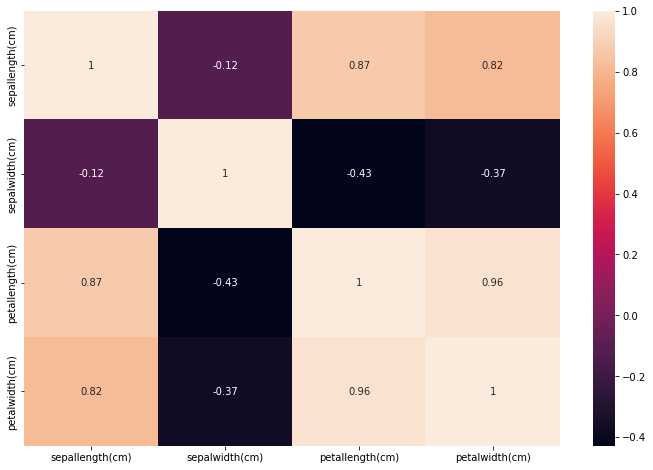

In [147]:
#plotting the correlation matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True)
plt.show()

As seen, there are direct proportions between "Chance of Admit" data and the other columns. In order to observe these direct proportions more clearly, we will visualize the data.

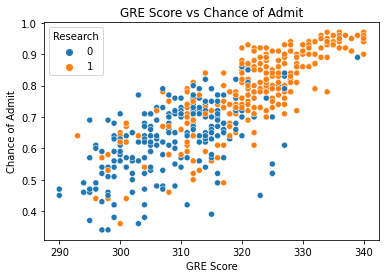

In [149]:
#plotting data which have high correlation
%matplotlib inline
import seaborn as sns
data=df
sns.scatterplot(data['GRE Score'], data['Chance of Admit'],data=df,hue=data['Research'])
plt.title("GRE Score vs Chance of Admit")
plt.show()

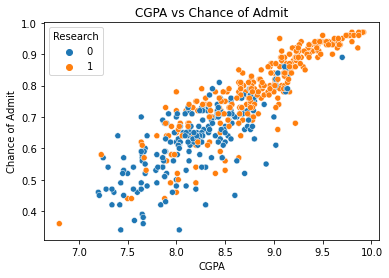

In [150]:
%matplotlib inline
import seaborn as sns
data =df
sns.scatterplot(data["CGPA"],data["Chance of Admit"],data=df,hue=data["Research"])
plt.title("CGPA vs Chance of Admit")
plt.show()

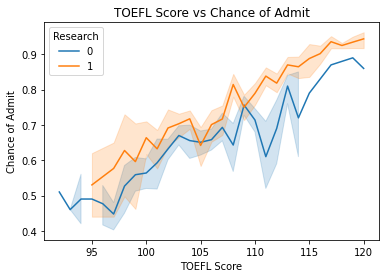

In [151]:
%matplotlib inline
import seaborn as sns
data=df
sns.lineplot(data["TOEFL Score"],data["Chance of Admit"],hue=data["Research"])
plt.title("TOEFL Score vs Chance of Admit")
plt.show()

Using matplotlib backend: agg


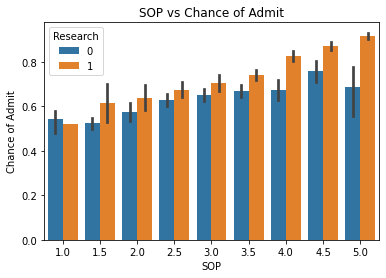

In [152]:
%matplotlib
import seaborn as sns
data=df
sns.barplot(data["SOP"],data["Chance of Admit"],hue=data["Research"])
plt.title("SOP vs Chance of Admit")
plt.show()

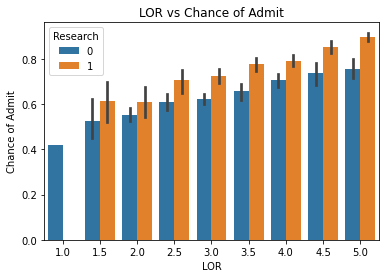

In [153]:
%matplotlib inline
import seaborn as sns
data=df
sns.barplot(data["LOR"],data["Chance of Admit"],hue=data["Research"])
plt.title("LOR vs Chance of Admit")
plt.show()

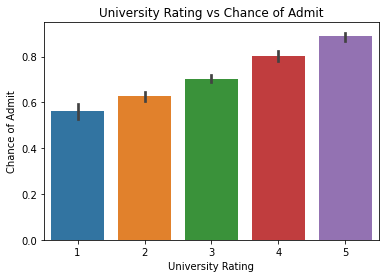

In [154]:
%matplotlib inline
import seaborn as sns
data=df
sns.barplot(data["University Rating"],data["Chance of Admit"])
plt.title("University Rating vs Chance of Admit")
plt.show()

It was said that there are direct proportions between the columns and "Chance of Admit" data. Also, when observing the graphs, there are linear relationships between them. Therefore, using Linear Regression method may be suitable on the data, but since "Chance of Admit" data depends on more than one varible, it is more appropriate to imply Multiple Linear Regression method instead of Linear Regression method.

## Importing the required libraries for regression analyzes

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Spliting the dataset into training and testing data

In [185]:
x = df[["GRE Score","TOEFL Score","University Rating","SOP","LOR","CGPA", "Research"]]
y = df["Chance of Admit"].values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## Multiple Linear Regression

In [ ]:
#implying multiple linear regression and determining its score

multiple_lin_reg = LinearRegression()
multiple_lin_reg.fit(x_train,y_train)

y_pred_mlr = multiple_lin_reg.predict(x_test)

r2_score_mlr = r2_score(y_test,y_pred_mlr)
print("Mutiple Linear Regression's Score = {:.3f}".format(r2_score_mlr))

Mutiple Linear Regression's Score = 0.819


## Decision Tree Regression

In [ ]:
#implying decision tree regression and determining its score

tree_reg = DecisionTreeRegressor()
tree_reg.fit(x_train,y_train)

y_pred_tree = tree_reg.predict(x_test)

r2_score_tree = r2_score(y_test,y_pred_tree)
print("Decision Tree Regression's Score = {:.3f}".format(r2_score_tree))

Decision Tree Regression's Score = 0.587


## Random Forest Regression

In [ ]:
#implying random forest regression and determining its score

ran_for_reg = RandomForestRegressor(n_estimators=100,random_state=42)
ran_for_reg.fit(x_train,y_train)

y_pred_rfr = ran_for_reg.predict(x_test)

r2_score_rfr = r2_score(y_test,y_pred_rfr)
print("Random Forest Regression's Score = {:.3f}".format(r2_score_rfr))

Random Forest Regression's Score = 0.787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


## Conclusion

R^2 score is an indicator of accuracy of regression models, and the accuracy is measured as close to 1 of this value .Therefore , as seen ,Multiple Linear Regression Models is brtter than Decision Tree Regression and Random Forest Regression on this dataset when comparing their R^2 scores



In [ ]:
!pip install ibm_watson_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Establising connection to IBM Watson ML sevice

In [ ]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "O-xbXqcCv2iPGZfem_krJ8KX-kQ2h5bKybYpPwY-gOfl"
}

client = APIClient(wml_credentials)

Python 3.7 and 3.8 frameworks are deprecated and will be removed in a future release. Use Python 3.9 framework instead.


## Creating Deployment Space

In [2]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return (next(item for item in space['resources'] if item['entity']['name']))

In [3]:
!pip install -U ibm-watson-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 12.1 MB/s 
     |████████████████████████████████| 51 kB 693 kB/s 
     |████████████████████████████████| 824 kB 33.9 MB/s 
     |████████████████████████████████| 133 kB 41.4 MB/s 
     |████████████████████████████████| 547 kB 45.9 MB/s 
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.7.0-py2.py3-none-any.whl size=72563 sha256=acab54ae975874477fa0ab6993637a7dc0af354cee8f3a216024760bd19be532
  Stored in directory: /root/.cache/pip/wheels/47/22/bf/e1154ff0f5de93cc477acd0ca69abfbb8b799c5b28a66b44c2
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.7.0-py2.py3-none-any.whl size=501013 sha256=0cb9b9de86500eb24d28ab3a82226bdec949bdf0dcb44e4f421a286c20596d33
  Stored in directory: /root/.cache/pip/wheels/6c/a2/e4/c16d02f809a3ea998e17cfd02c13369281f3d232aaf5902c19
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos

In [4]:
wml_credentials = {"apikey":"","url":"https://us-south.ml.cloud.ibm.com"}


In [5]:
!pip install eiapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install -q kaggle

In [58]:
from google.colab import files

In [10]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
db-dtypes==1.0.4
debugpy==1.0.

In [11]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "O-xbXqcCv2iPGZfem_krJ8KX-kQ2h5bKybYpPwY-gOfl"
}

wml_client = APIClient(wml_credentials)
wml_client.spaces.list(1)

Python 3.7 and 3.8 frameworks are deprecated and will be removed in a future release. Use Python 3.9 framework instead.
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
a5d3879c-fce2-421a-a352-9e2bbb589332  Regression-Models  2022-11-11T06:28:48.106Z
------------------------------------  -----------------  ------------------------


In [13]:
SPACE_ID="a5d3879c-fce2-421a-a352-9e2bbb589332"
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [71]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
a5d3879c-fce2-421a-a352-9e2bbb589332  Regression-Models  2022-11-11T06:28:48.106Z
------------------------------------  -----------------  ------------------------


In [14]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

## Perpsisting The Multiple Linear Regression Model And Deploying It In Ibm cloud

In [73]:
import sklearn
sklearn.__version__

'1.0.2'

In [74]:
#Set Python Version
software_spec_uid = wml_client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [175]:
MODEL_NAME='Regression-demo '
DEPLOYMENT_NAME='Regression-Model'
DEMO_MODEL= model

In [176]:
#set python version
software_spec_uid=wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [177]:
software_spec_uid = wml_client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid
model_props={
    wml_client.repository.ModelMetaNames.NAME: "MODEL_NAME",
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.0",
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}


In [106]:
import pandas as pd

In [107]:
X = df.iloc[:, :-1]
y = df['class']

In [108]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=50)

In [109]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=40)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=40)

In [110]:
from sklearn.metrics import accuracy_score
y_predict = model.predict(x_test)
accuracy_score(y_test, y_predict)

0.9666666666666667

In [111]:
pd.crosstab(y_test, y_predict)

col_0,Iris-setosa,Iris-versicolor,Iris-virginica
class,,,
Iris-setosa,9,0,0
Iris-versicolor,0,11,1
Iris-virginica,0,0,9


In [114]:
!pip install -U ibm-watson-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
deployment_props={
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
    wml_client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [116]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [117]:
pwd

'/content'

In [159]:
#Save model
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props, 
    training_data=x_train, 
    training_target=y_train
)

Status code: 404, body: {"trace":"bbe0b0f8aac3fdad566d6ce49dc1cf96","errors":[{"code":"training_job_run_not_found","message":"Illegal character in path at index 124: https://c9662117-ff86-4053-a22a-524554651c32-bluemix.cloudant.com:443/wml-training-prod/a5d3879c-fce2-421a-a352-9e2bbb589332 ","more_info":"http://watson-ml-api.mybluemix.net/"}],"status_code":"404"}


UnexpectedType: ignored

In [125]:
model_details

NameError: ignored

In [126]:
model_id = wml_client.repository.get_model_id(model_details)
model_id

NameError: ignored

## Testing

In [160]:
x_train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
249,321,111,3,3.5,4.0,8.83,1
433,316,111,4,4.0,5.0,8.54,0
19,303,102,3,3.5,3.0,8.50,0
322,314,107,2,2.5,4.0,8.27,0
332,308,106,3,3.5,2.5,8.21,1
...,...,...,...,...,...,...,...
106,329,111,4,4.5,4.5,9.18,1
270,306,105,2,2.5,3.0,8.22,1
348,302,99,1,2.0,2.0,7.25,0
435,309,105,2,2.5,4.0,7.68,0


In [168]:
multiple_lin_reg.predict(x_train)

AttributeError: ignored

## UASEP Multiple Linear Regression Model Deployment Test

In [39]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "O-xbXqcCv2iPGZfem_krJ8KX-kQ2h5bKybYpPwY-gOfl"
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey":
 API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"field": [["GRE Score","TOEFL Score","University Rating","SOP","LOR ","CGPA", "Research"]], "values": [[326, 110, 2, 3.5, 4, 9.23, 1]]}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/uaep_deployment/predictions?version=2022-11-12', json=payload_scoring,
 headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Scoring response
{'predictions': [{'fields': ['prediction'], 'values': [[[0.8448151378927107]]]}]}


In [40]:
probability = response_scoring.json()['predictions'][0]['values'][0][0][0]
probability

0.8448151378927107